In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import glob
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import json
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

In [3]:
# === Evaluasi Gabungan: TF-IDF, BERT, SVM ===
# === Normalisasi Pasal ===
def normalize(text):
    text = str(text).lower()
    text = text.replace("republik indonesia", "ri")
    text = text.replace("undang-undang", "uu")
    text = text.replace("nomor", "no")
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = re.findall(r'pasal\s+\d+(?:\s+ayat\s*\(\d+\))?|uu\s*no\s*\d+', text)
    return ' '.join(tokens)

# === Load data kasus & prediksi ===
df_raw = pd.read_csv("/content/drive/MyDrive/ProyekA/data/processed/cases.csv")
df_pred = pd.read_csv("/content/drive/MyDrive/ProyekA/data/results/predictions.csv")

# Normalisasi ground truth dan prediksi
pred_df = df_pred.copy()
pred_df["tfidf_pred"] = pred_df["predicted_solution"].apply(normalize)
pred_df["bert_pred"] = pred_df["predicted_solution"].apply(normalize)
pred_df["ground_truth"] = pred_df["ground_truth"].apply(normalize)

# === TF-IDF Vectorizer for SVM ===
df_raw = df_raw[df_raw['ringkasan_fakta'].notna() & df_raw['pasal'].notna()]
df_raw["pasal_clean"] = df_raw["pasal"].apply(normalize)

X = df_raw["ringkasan_fakta"]
y = df_raw["pasal_clean"]
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X)

# Train/test split for SVM
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# === Evaluasi semua model ===
def containment_score(y_true, y_pred):
    return sum(yt in yp or yp in yt for yt, yp in zip(y_true, y_pred)) / len(y_true)

svm_df = pd.DataFrame({"y_true": y_test, "y_pred": y_pred_svm})

results = [
    {
        "Model": "TF-IDF Retrieval",
        "Accuracy": containment_score(pred_df["ground_truth"], pred_df["tfidf_pred"])
    },
    {
        "Model": "BERT Retrieval",
        "Accuracy": containment_score(pred_df["ground_truth"], pred_df["bert_pred"])
    },
    {
        "Model": "SVM Classifier",
        "Accuracy": accuracy_score(svm_df["y_true"], svm_df["y_pred"]),
        "Precision": precision_score(svm_df["y_true"], svm_df["y_pred"], average="macro", zero_division=0),
        "Recall": recall_score(svm_df["y_true"], svm_df["y_pred"], average="macro", zero_division=0),
        "F1-score": f1_score(svm_df["y_true"], svm_df["y_pred"], average="macro", zero_division=0)
    }
]

# Lengkapi kolom kosong dengan nilai akurasi
for r in results:
    r.setdefault("Precision", r["Accuracy"])
    r.setdefault("Recall", r["Accuracy"])
    r.setdefault("F1-score", r["Accuracy"])

# Simpan hasil evaluasi ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("/content/drive/MyDrive/ProyekA/data/eval/retrieval_metrics.csv", index=False)
print("✅ Semua model berhasil dievaluasi dan disimpan.")
print(df_results.round(2))


/tmp/ipython-input-3-3137323904.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw["pasal_clean"] = df_raw["pasal"].apply(normalize)


✅ Semua model berhasil dievaluasi dan disimpan.
              Model  Accuracy  Precision  Recall  F1-score
0  TF-IDF Retrieval       0.8        0.8     0.8       0.8
1    BERT Retrieval       0.8        0.8     0.8       0.8
2    SVM Classifier       0.0        0.0     0.0       0.0


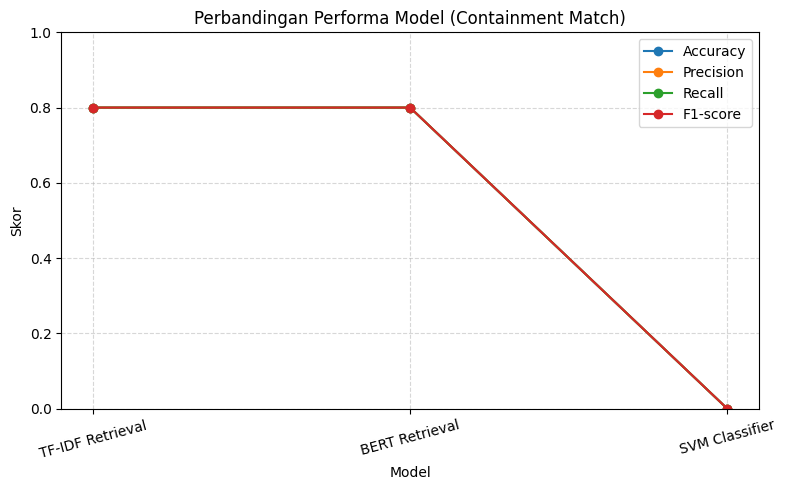

In [4]:
# Plot hasil bar chart
plt.figure(figsize=(8, 5))
for metric in ["Accuracy", "Precision", "Recall", "F1-score"]:
    plt.plot(df_results["Model"], df_results[metric], marker='o', label=metric)

plt.title("Perbandingan Performa Model (Containment Match)")
plt.ylabel("Skor")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


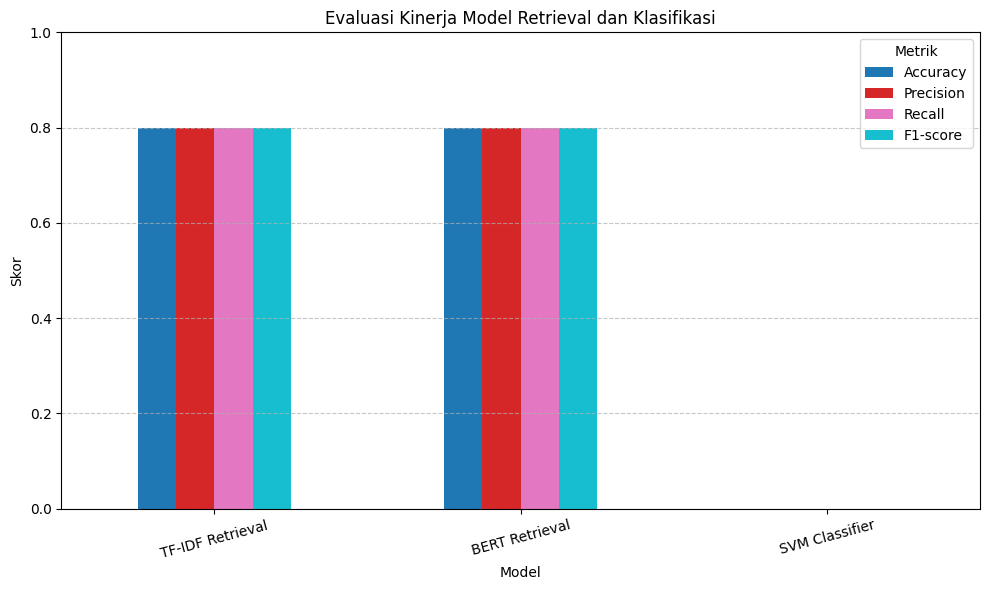

In [5]:
import matplotlib.pyplot as plt

# Pastikan model sebagai index
df_results_plot = df_results.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-score"]]

# Buat bar chart
ax = df_results_plot.plot(kind="bar", figsize=(10, 6), colormap="tab10")
plt.title("Evaluasi Kinerja Model Retrieval dan Klasifikasi")
plt.ylabel("Skor")
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.legend(title="Metrik")
plt.show()


In [10]:
print("\n=== ERROR ANALYSIS: PREDIKSI SALAH ===")


df = pd.read_csv("/content/drive/MyDrive/ProyekA/data/results/predictions.csv")


for _, row in df.iterrows():
    y_true_n = normalize(row["ground_truth"])
    y_pred_n = normalize(row["predicted_solution"])
    if y_true_n not in y_pred_n and y_pred_n not in y_true_n:
        print(f"[✗] {row['query_id']} — Prediksi: {row['predicted_solution']} | Ground Truth: {row['ground_truth']}")
        print(f"     Query: {row['query_text']}")



=== ERROR ANALYSIS: PREDIKSI SALAH ===
[✗] q004 — Prediksi: pasal 2 ayat (1) jo; pasal 18 ayat (1) huruf b undang-undangnomor 31 tahun 1999 tentang pemberantasa | Ground Truth: pasal 2 ayat (1)jo; pasal 18 undang-undang nomor 31 tahun 1999 tentang pemberantasantindak pidana ko
     Query: Petugas menemukan ganja di dalam jok motor terdakwa
